# Pré-requis et packages nécessaires

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
pd.options.mode.chained_assignment = None
import math
from datetime import datetime
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import sys
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
from tqdm import tqdm
pyLDAvis.enable_notebook()
from tabulate import tabulate
import seaborn as sns
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/carolineboudier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carolineboudier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# I. Extraction des données

La première étape est d'extraire les tweets grâce à l'API twitter. Le code complet d'extraction a été joint (fichier "Fichier_Final_Extraction" ) mais dans les grandes lignes le travail consiste à : 
- définir les **paramètres de la recherche.** Dans notre cas nous allons nous intéresser aux tweets *en français* sur une période d'*une semaine* (08/01/2021 au 13/01/2021). Une première analyse sur Twitter permet de remarquer que la plupart des tweets d'opinion sur le vaccin ne sont pas dôtés du hashtag #vaccin. Pour ne pas biaiser l'étude (et notamment parce que les hashtags semblent être plus utilisés par certains acteurs spécifiques : médias, chaînes d'information), on décide d'inclure *tous les tweets portant la mention "vaccin"* (qui peut aussi être le radical du mot ie vaccination, vaccinés, vaccinent etc.)
- faire une **query sur l'API** en indiquant comme paramètres : les dates, la langue, le filtre utilisé. Compte tenu du nombre important de tweets, la requête doit être faite en plusieurs fois. On n'inclue volontairement pas les retweets dans l'analyse pour éviter d'avoir trop de doublons. 
- À partir de la donnée brute extraite sur Twitter, **structurer la donnée** dans un dataframe dont les colonnes reprennent des informations *sur le tweet* (id, contenu, date, géolocalisation, hashtag, catégorie du tweet : citation, réponse à un autre tweet) et sur *l'utilisateur* (nom, description, localisation, date de création, nombre de followers, nombre de favoris, utilisateur vérifié ou non). 

In [554]:
# on crée le df
tw_data=pd.read_csv('clean_and_final_data.csv')
print("Le dataset comporte {} tweets".format(len(tw_data)))

Le dataset comporte 42557 tweets


In [555]:
tw_data.head()

,tweet_id,date,text,tweet_location,hashtags,is_retweet,is_reply,is_quote_status,user_name,user_location,user_description,user_created,user_followers,user_favourites,user_verified
0,1348781696041279489,2021-01-11 23:59:50,hahaha y’a des gens ils veulent trop faire les...,NaN,NaN,False,NaN,True,Pazzo🇫🇷👽,mtp zoo,Montpellier Fans. soldat d’la team @jul,2020-10-30 11:40:01,376.0,5620.0,False
1,1348781685333241860,2021-01-11 23:59:47,@JJBourdin_RMC Un personne peut être anti-vacc...,NaN,NaN,False,JJBourdin_RMC,False,Ysa Bellule,France,NaN,2019-12-15 17:47:30,13.0,5214.0,False
2,1348781616324354048,2021-01-11 23:59:31,@anosylx @NassiraELM @clobala2 Le vaccin c'est...,NaN,NaN,False,anosylx,False,Rémi-Ange Couzinet,"Roubaix, France",médiateur social solidaire de toutes les vies ...,2013-01-24 12:06:50,583.0,54273.0,False
3,1348781548217245698,2021-01-11 23:59:14,@glamchloo_ C’est soit ils gardent couvre feu ...,NaN,NaN,False,glamchloo_,False,Alossss dans l’cosmos,"Ardennes, Champagne-Ardenne",NaN,2014-06-07 20:28:37,262.0,9951.0,False
4,1348781543330893825,2021-01-11 23:59:13,@kassem_romain @QuentinChaine @DIVIZIO1 Dans t...,NaN,NaN,False,kassem_romain,False,Habib Richer,NaN,Un simple observateur.,2020-08-13 10:14:01,18.0,257.0,False


In [83]:
# On affiche les données du premier tweet pour se familiariser avec les données
for column in tw_data.columns:
  print(column + " : "+str(tw_data[column][0]))

tweet_id : 1348781696041279489
date : 2021-01-11 23:59:50
text : hahaha y’a des gens ils veulent trop faire les rebelles à pas vouloir le vaccin mais quand va falloir le montrer pour aller au ciné ou à l’hôtel avec une meuf ils vont vite courir le faire https://t.co/dmYrY5bO7y
tweet_location : nan
hashtags : nan
is_retweet : False
is_reply : nan
is_quote_status : True
user_name : Pazzo🇫🇷👽
user_location : mtp zoo
user_description : Montpellier Fans. soldat d’la team @jul
user_created : 2020-10-30 11:40:01
user_followers : 376.0
user_favourites : 5620.0
user_verified : False


# II. Nettoyage des données textuelles

Un des défis les plus importants dans l'analyse de tweets est d'arriver à une donnée de qualité. Pour ce faire on crée une fonction clean_tweet dont l'objectif est de renvoyer un tweet propre à partir d'un tweet brut. On rajoute ensuite deux colonnes au dataframe (donnée propre sous forme de vecteurs et sous forme de liste de mots). 

## 1) Pré-requis

In [84]:
# On crée une stoplist à laquelle on rajoute quelques éléments par la suite
stoplist = stopwords.words('french')
rajouts_stoplist=['ça','a','fait','tout']
stoplist = stoplist+rajouts_stoplist

# on s'assure de ne pas supprimer les @ pour pouvoir ensuite identifier les tags
string_punc=string.punctuation.replace('@','')+str('«')+str('«')

# on s'assure également de supprimer les emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

## 2) Fonction clean_tweet()

In [86]:
# on peut maintenant créer la fonction clean_tweet
def clean_tweet(tweet):
  # on remplace les apostrophes par des espaces
    tweet=tweet.replace('\''," ")
    tweet=tweet.replace('’'," ")

  # on retire la ponctuation (sauf les @)
    for char in string_punc:
        tweet=tweet.replace(char,'')
    # on retire les émojis
        tweet=remove_emoji(tweet)
    final_vec=[]
    for word in tweet.split():
    # minuscules
        word=word.lower()
    # on retire les noms d'utilisateurs cités, les stopwords et les url
        if word[0]!="@" and (word[0:4]!='http') and (word not in stoplist):
        # on retire les chiffres
            if not word.isnumeric():
              final_vec.append(word)
    return final_vec

## 3) Intégration au dataframe de la donnée propre

In [563]:
# on rajoute une colonne avec le contenu propre sous forme de vecteur
tw_data['clean_vector']=[clean_tweet(tweet) for tweet in tw_data['text'].values]

# on rajoute une colonne avec le contenu propre sous forme de phrases
tw_data['clean_sentance']=[(' ').join(clean_tweet(tweet)) for tweet in tw_data['text'].values]
# on peut ici supprimer les tweets dont le contenu était identique (mais pas un retweet)
tw_data.drop_duplicates(subset=["clean_sentance"],inplace=True)

# on concatène tous les vecteurs dans une liste
bag_of_words_list=tw_data['clean_vector'].values.sum()
# on concatène tous les vecteurs dans une phrase
bag_of_words=(' ').join(bag_of_words_list)

Notre dataframe contient désormais deux colonnes avec le texte propre. On peut regarder un exemple.

In [564]:
tw_data[['text','clean_vector','clean_sentance']][0:2]

,text,clean_vector,clean_sentance
0,hahaha y’a des gens ils veulent trop faire les...,"[hahaha, gens, veulent, trop, faire, rebelles,...",hahaha gens veulent trop faire rebelles vouloi...
1,@JJBourdin_RMC Un personne peut être anti-vacc...,"[personne, peut, être, antivaccin, être, impat...",personne peut être antivaccin être impatiente ...


# III. Première analyse et segmentation par LDA

## 1) Premier aperçu : mots les plus fréquents

On va s'intéresser aux hashtags, aux unigrammes (mots uniques) et aux bigrammes (couple de mots) les plus fréquents afin d'avoir un premier aperçu de notre jeu de données. 

In [92]:
# HASHTAGS LES PLUS UTILISÉS
hashtag_list=[]
for hash in tqdm(tw_data['hashtags']):
  # on se débarasse des nan
  if isinstance(hash, str):
    # traitement à faire car la structure de nos hashtags est particulière
    hash=hash.replace('[','')
    hash=hash.replace(']','')
    hash=hash.replace('\'','')
    hash=hash.split(',')
    for element in hash:
      # on met en minuscule et on enlève les espaces
        element=element.replace(' ','')
        element=element.lower()
        hashtag_list.append(element)

100%|██████████| 39561/39561 [00:00<00:00, 1098741.62it/s]


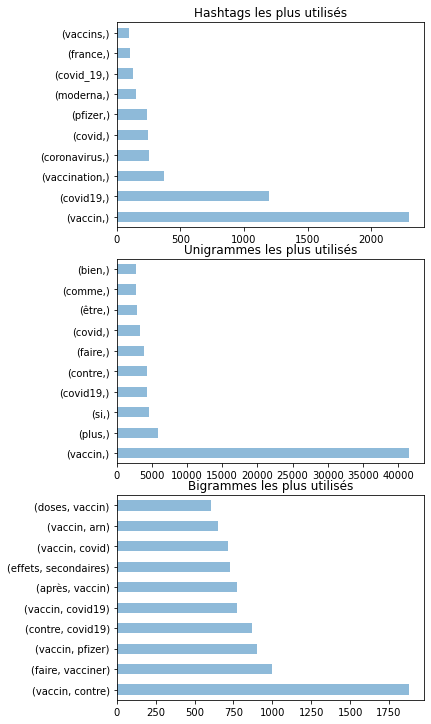

In [93]:
# on peut maintenant tracer des histogrammes
fig, ax = plt.subplots(3,1,figsize=(5,10))
fig.tight_layout()

#hashtags
common_hashtags=pd.DataFrame(hashtag_list,columns=['hashtag']).value_counts().sort_values(ascending=False)
common_hashtags.head(10).plot(kind='barh',ax=ax[0],alpha=0.5)
ax[0].set_title('Hashtags les plus utilisés')
ax[0].set_ylabel('')


#unigrammes
common_unigrams=pd.DataFrame(bag_of_words_list,columns=['unigram']).value_counts().sort_values(ascending=False)
common_unigrams.head(10).plot(kind='barh',ax=ax[1],alpha=0.5)
ax[1].set_title('Unigrammes les plus utilisés')
ax[1].set_ylabel("")

#bigrammes
bigrams=list(nltk.bigrams(bag_of_words_list))
common_bigrams=pd.DataFrame(bigrams,columns=['bigram_first_word','bigram_second_word']).value_counts().sort_values(ascending=False)
common_bigrams.head(10).plot(kind='barh',ax=ax[2],alpha=0.5)
ax[2].set_title('Bigrammes les plus utilisés')
ax[2].set_ylabel("")
plt.show()

- On retrouve des mots cohérents : liés à la vaccination ("vaccin", "faire vacciner", "vaccination"), à la maladie ("covid19", "coronavirus" etc), aux marques ("pfizer", "moderna" etc). On remarque également  que les bigrammes "vaccin arn" et "effets secondaires" sont parmi les bigrammes les plus prévalents. 
- On peut également représenter un nuage de mots. La fonction word_cloud permet d'afficher les unigrammes et bigrammes les plus fréquents. Plus la taille d'un mot (ou groupe de mot) est élevée, plus le mot est présent dans le dataset. On retrouve logiquement les mêmes mots que dans les graphiques précédents sous une forme plus visuelle. 

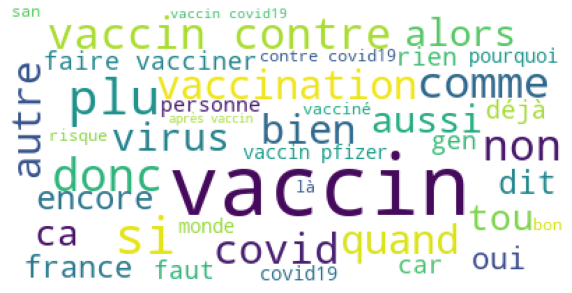

In [557]:
fig, ax = plt.subplots(figsize=(10,10))

# relative scaling=0.5 permet de pondérer aussi bien le nombre d'occurences du mot que le rang du mot
wordcloud = WordCloud(background_color='white',
                          max_words=40,
                          max_font_size=60,relative_scaling=0.5,collocations=True).generate(bag_of_words)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 2) Segmentation des sujets via la LDA

- Une fois notre dataset pris en main nous allons essayer d'identifier des thèmes dans les débats liés aux vaccins. Pour ce faire nous recourrons à un modèle de LDA (Latent Dirichlet Allocation). 
- Pour entraîner un modèle LDA on lui fournit une collection de documents sous la forme d'un ensemble de vecteurs de même taille (ici la taille du vocabulaire). Le modèle LDA va grouper les documents dans différents clusters en partant du principe que les documents appartenant à un même topic ont recours à un vocabulaire proche.  
- Après de premiers essais et afin d'éviter que les mots les plus courants (et en particulier "vaccin") ne viennent polluer notre modèle, on s'assure d'exclure dans le modèle les mots présents dans plus de 80% des documents. 

### Fonctions de base

On commence par créer deux fonctions de base : la première entraîne un modèle LDA à partir d'une base de documents et un nombre de topics prédéfini. La seconde permet d'afficher les mots clés les plus présents pour chaque topic identifié par le modèle. 

In [558]:
# fonction LDA (renvoie trois arguments : le modèle, le corpus et le dico)
def create_LDA_model(clean_documents,n_topics):
    final_dict={}
    # on crée un dictionnaire à partir de notre base de documents
    dico = corpora.Dictionary(clean_documents)
    # on retire les mots présents dans + de 80% du dataset et les mots avec moins de 5 occurences
    dico.filter_extremes(no_above=0.8,no_below=5) 
    # on sauvegarde le dictionnaire
    final_dict['dico']=dico
    # on crée un corpus à partir de nos documents
    corpus = [dico.doc2bow(document) for document in clean_documents]
    # on sauvegarde le corpus
    final_dict['corpus']=corpus
    #on entraîne le modèle
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dico,num_topics=n_topics,passes=3)
    final_dict['model']=lda_model
    return(final_dict) # le modèle renvoie donc pour une base de documents le dictionnaire, le modèle et le corpus

# fonction afficher les topics et les mots les plus présents
def build_topic_list(lda_model,no_words,n_topics):
    dict={}
    columns=['keywords_list']+['Weights_n°1']
    columns+=["W_n°"+str(i+1) for i in range(1,no_words)]
    for i in range(0,n_topics):
        keyword_vector=lda_model.show_topic(i)
        keyword_list=np.asarray(", ".join([word for word,prop in keyword_vector][0:no_words]))
        prop_list=[round(100*prop,1) for word,prop in keyword_vector][0:no_words]
        final_list=np.append(keyword_list,prop_list)
        dict["Topic %d" %(i)]=final_list
    return(pd.DataFrame.from_dict(dict,orient='index',columns=columns))

### Modèle de base

- On commence par un premier essai avec un nombre arbitraire de 5 sujets, le modèle LDA renvoie les cinq sujets avec les mots les plus présents dans le topic ainsi que le poids associé à chaque mot. 

In [95]:
# MODÈLE DE BASE
clean_documents_base=[clean_tweet for clean_tweet in tw_data['clean_vector'].values]
lda_base=create_LDA_model(clean_documents_base,n_topics=5)

# on affiche le dictionnaire avec les topics et les mots les plus courants
base_topic_list=build_topic_list(lda_model=lda_base['model'],no_words=10,n_topics=5)
base_topic_list

,keywords_list,Weights_n°1,W_n°2,W_n°3,W_n°4,W_n°5,W_n°6,W_n°7,W_n°8,W_n°9,W_n°10
Topic 0,"covid19, contre, vaccination, covid, graves, n...",2.2,1.8,1.3,1.0,0.9,0.8,0.8,0.8,0.7,0.7
Topic 1,"arn, virus, sans, vaccins, variant, cette, plu...",1.4,1.2,0.8,0.8,0.8,0.7,0.7,0.6,0.6,0.6
Topic 2,"si, faire, plus, non, rien, comme, effets, vac...",1.8,1.5,1.4,1.0,0.9,0.9,0.9,0.9,0.8,0.8
Topic 3,"plus, si, être, faire, covid, va, bien, virus,...",1.9,1.1,1.1,1.0,1.0,0.9,0.8,0.8,0.8,0.7
Topic 4,"covid19, après, vaccination, contre, doses, pf...",4.6,2.2,2.1,2.0,1.8,1.7,1.4,1.4,1.2,1.2


### Choix de l'hyperparamètre : nombre de topics

Pour choisir le meilleur nombre de topics on utilise le score de cohérence. La cohérence permet de mesurer la pertinence d'un topic en mesurant la similarité entre les mots les plus importants de ce topic. On utilise la mesure c_v qui se fonde sur la similarité cosinus et la NPMI (information mutuelle ponctuelle normalisée qui quantifie le rapport entre la loi jointe/proba que deux événènements coincident et le produit de leurs lois marginales). 

On commence par créer deux fonctions de base permettant l'une de calculer la cohérence du modèle, l'autre de dessiner un graphique indiquant la cohérence pour différents nombres de topics. 

In [96]:
# fonction coherence score
def calcul_coherence(model,documents,type='c_v'):
    corpus=model['corpus']
    dico=model['dico']
    model=model['model']
    coherence_model_lda = CoherenceModel(model,texts=documents,corpus=corpus,dictionary=dico,coherence=type)
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

def draw_coherence(documents,min=1,max=10,type='c_v'):
    coherence_scores=[]
    for n_topics in tqdm(range(min,max+1)):
        model=create_LDA_model(documents,n_topics=n_topics)
        coh=calcul_coherence(model,documents=documents,type=type)
        coherence_scores.append(coh)
    fig, ax = plt.subplots(figsize=(5,5))
    label=range(min,max+1)
    plt.plot(label,coherence_scores)
    ax.set_title('Variation du score de cohérence en fonction du nombre de topics :({})'.format(type))
    plt.show()

On peut désormais tracer le graphique indiquant la cohérence du modèle pour différents nombres de topics (entre 1 et 10). 

100%|██████████| 10/10 [05:24<00:00, 32.46s/it]


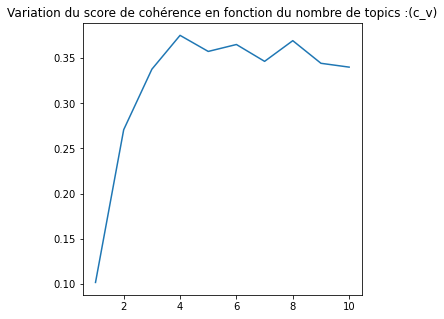

In [97]:
# on trace la cohérence en fonction du nombre de topics
draw_coherence(documents=clean_documents_base)

On constate que le gain marginal de cohérence est négatif ou très faible lorsqu'on dépasse quatre topics. On décide donc de s'en tenir à quatre topics majeurs et on construit notre modèle final. 

# IV. Exploration des groupes obtenus via la LDA

On choisit donc **comme modèle final le modèle à 4 topics**. Il s'agit maintenant de mieux comprendre les thèmes ressortis de la segmentation. Il s'agit d'un processus délicat, on va donc utiliser plusieurs méthodes qu'on recroisera pour arriver à des résultats satisfaisants : analyse lexicale, tweets les plus probables, utilisateurs les plus représentatifs pour chaque topic, polarité/objectivité de chaque topic. 

In [318]:
lda_final=create_LDA_model(clean_documents_base,n_topics=4)

Topic 0    plus, pfizer, arn, vaccins, covid19, contre, a...
Topic 1    covid19, vaccination, contre, après, france, d...
Topic 2    faire, rien, si, plus, bien, vacciner, va, non...
Topic 3    plus, si, virus, covid, faire, donc, comme, no...
Name: keywords_list, dtype: object

## 1) Exploration des sujets et des mots

In [561]:
# mots les plus présents dans chacun des sujets
build_topic_list(lda_model=lda_final['model'],no_words=10,n_topics=4)
for i, element in enumerate(base_topic_list['keywords_list']):
    print('\nTopic' +str(i))
    print(element)


Topic0
plus, pfizer, arn, vaccins, covid19, contre, ans, efficacité, virus, comme

Topic1
covid19, vaccination, contre, après, france, doses, coronavirus, via, dose, avoir

Topic2
faire, rien, si, plus, bien, vacciner, va, non, être, contre

Topic3
plus, si, virus, covid, faire, donc, comme, non, être, contre


Pour ce faire une meilleure idées des thèmes on utilise une visualisation Davis. Chaque bulle représente un topic - plus grosse est la bulle, plus le topic est prévalent. Sur la fenêtre de droite le paramètre lambda sert à ajuster le score de "pertinence". La documentation du modèle nous indique que la pertinence du mot w dans le sujet k est calculée comme indiquée ci-dessous: 

$r(w|k)=\lambda \times log(\phi_{kv})+(1-\lambda)\times log(\frac{\phi_{kv}}{p_w})$ avec $p_{w}$ la distribution du mot dans le corpus, $\phi_{kv}$ distribution du mot dans le topic. 

Quand $\lambda$ vaut 1 il s'agit simplement du mot le plus présent dans le topic, quand $\lambda$ diminue on prend de plus en plus compte les mots **relativement** très présents dans le topic (par rapport au reste du corpus) ce qui permet d'identifier des mots très spécifiques à chaque topic. 

In [365]:
vis = pyLDAvis.gensim.prepare(lda_final['model'], lda_final['corpus'], lda_final['dico'],sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.015713  0.173663       1        1  24.985656
1     -0.233489 -0.047370       2        1  20.116918
2      0.109158 -0.132607       3        1  23.292555
3      0.108618  0.006314       4        1  31.604871, topic_info=            Term         Freq        Total Category  logprob  loglift
229      covid19  4852.000000  4852.000000  Default  30.0000  30.0000
331  vaccination  2779.000000  2779.000000  Default  29.0000  29.0000
29         après  2459.000000  2459.000000  Default  28.0000  28.0000
210       france  1513.000000  1513.000000  Default  27.0000  27.0000
126        doses  1369.000000  1369.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
162        moins   624.375385  1239.441242   Topic4  -5.5090   0.4662
47          dire   630.697199  1285.774108   Topic4  -5.4989   0.4396
133        alors   673.652223  1659.472049   Topic4  -5.4330   0.2503
20          peut   677.156733  1752.407566   Topic4  -5.4278   0.2010
73         avoir   655.049013  2132.941881   Topic4  -5.4610  -0.0287

[361 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1318      1  0.006915            1ère
1318      2  0.988832            1ère
1318      4  0.006915            1ère
167       1  0.991408              2e
904       2  0.997643  administration
...     ...       ...             ...
2347      2  0.004368               🤣
2347      3  0.856181               🤣
4585      4  0.991886              🤣🤣
2973      1  0.010926              🤷‍
2973      4  0.983295              🤷‍

[736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

On peut déjà remarquer grâce aux mots et à la visualisation que : 
- le sujet 1 est le seul pour lequel les termes "arn" et "messager" apparaîssent ainsi que des termes spécifiques tels que "thérapie", "immunité, "variant", "génique" etc. On a l'intuition que ce thème est plutôt "scientifique".
- le sujet 2 se caractérise par des mots issus de gestion politique de la vaccination : "dose", "france", "europe", "campagne", "français", "millions". 
- Les sujets 3 et 4 sont plus difficiles à différencier. Ils semblent tous les deux caractérisés par des jugements de valeur et des opinions. On peut remarquer que le sujet 3 semble finalement utiliser du lexique plus général sur la période de pandémie ("liberté", "masque", "droit", "gouvernement", "monde") quand le sujet 4 est plus centré sur des thèmes liés au vaccin et à la maladie ("effets secondaires", "protège", "cas graves"). 

## 2) Tweets les plus représentatifs pour chaque classe

On va pour chaque document de la base de données associer un vecteur de probabilités pour chaque topic (topic_dis), le topic le plus probable (main_topic) et le pourcentage de probabilité pour ce topic (perc_main_topic). Par exemple pour le premier tweet de la base de données (dont on affiche la sortie) le topic identifié est le deuxième topic avec une probabilité de 37%. 

In [565]:
# on récupère la proba de chaque topic pour chaque tweet
tw_data['topic_dis']=tw_data['clean_vector'].apply(lambda x : lda_final['model'].get_document_topics(lda_final['dico'].doc2bow(x)))
# on trie le vecteur de probabilités de façon à avoir le topic le plus probable en premier
tw_data['sorted_topic']=tw_data['topic_dis'].apply(lambda x :sorted(x,key=lambda x: (x[1]),reverse=True))
# on extrait le topic le plus probable et sa proba associé
tw_data['main_topic']=tw_data['sorted_topic'].apply(lambda x :x[0][0])
tw_data['perc_main_topic']=tw_data['sorted_topic'].apply(lambda x :x[0][1])

In [566]:
tw_data[['text','topic_dis','main_topic','perc_main_topic']].head(1)

,text,topic_dis,main_topic,perc_main_topic
0,hahaha y’a des gens ils veulent trop faire les...,"[(0, 0.24085231), (1, 0.012797809), (2, 0.3734...",2,0.373405


On peut ensuite pour chaque catégorie afficher les cinq tweets les plus représentatifs. 

In [571]:
for i in range(0,4):
    df=tw_data[tw_data['main_topic']==i].sort_values(by='perc_main_topic',ascending=False)
    print('TWEET LES PLUS PROBABLES POUR LE TOPIC {} : '.format(i+1))
    for j in range(0,5):
        print("Tweet n*"+str(j+1))
        print(df['text'].values[j].strip())
    print('\\')

TWEET LES PLUS PROBABLES POUR LE TOPIC 1 : 
Tweet n*1
et l'ARN ne reste pas dans la cellule 
de façon permanente car la cellule détruit l'ARN assez rapidement
 
donc,il n'y a aucun risque qu'un vaccin à ARN modifie génétiquement le génome d'une personne

cela semble être une réponse solide 
c’est la réponse des fabricants de vaccins
Tweet n*2
Sur l'enjeu des vaccins, ils se foutent de ce que le fédéral peut dire, au sujet du délai pour le 2e vaccin.
Quand je vous disais que le risque est très élevé:  gaspillage de tous les vaccins et/ou protection diminuée.
Dès le début, les compagnies productrices ont bien établi
Tweet n*3
🇫🇷 "Notre vaccin protégera sans doute une personne de moins de 55 ans en bonne santé pour plusieurs années. Mais pour celles qui sont plus âgées et à la santé déjà fragile, la durée sera peut-être plus courte" Stéphane Bancel, PDG de Moderna (L’Express) https://t.co/emKsXRfEud
Tweet n*4
@Lilly_Crem C’est la technique même de l’arn qui permet au vaccin d’être conçu r

S'il est difficile de trop s'avancer avec cet échantillon, on retrouve tout de même le fait que le topic 1 semble associé avec le thème de l'ARN qui revient sur trois tweets et sur des discussions utilisant des thèmes scientifiques. Le topic 2 semble lui associé avec des tweets officiels (venant de médias notamment) ce qui explique qu'on y ait retrouvé des informations à caractère plus politique. Le topic 3 est bien lié avec la pandémie de manière plus générale (mesures barrières, confinement) alors que le topic 4 semble centré sur le débat autour de la vaccination avec des arguments pas toujours très objectifs ...

## 3) Analyse de subjectivité et de polarité

On va coupler notre analyse avec une analyse de sentiments en utilisant le module TextBlob. Pour une phrase donnée, le module accorde un score de polarité (positif = 1, négatif=-1) et de subjectivité (0=objectif, 1=subjectif) à la phrase à partir d'un lexique de mots annotés. On rajoute à notre dataframe la polarité et la subjectivité. Puis on trace des graphiques pour chacun des topics et on calcule les scores moyens (ainsi que les quartiles) pour chacun des topics. 

In [572]:
tw_data['polarity']=tw_data['text'].apply(lambda x : TextBlob(x,pos_tagger=PatternTagger(),analyzer=PatternAnalyzer()).sentiment[0])
tw_data['objectivity']=tw_data['text'].apply(lambda x : TextBlob(x,pos_tagger=PatternTagger(),analyzer=PatternAnalyzer()).sentiment[1])

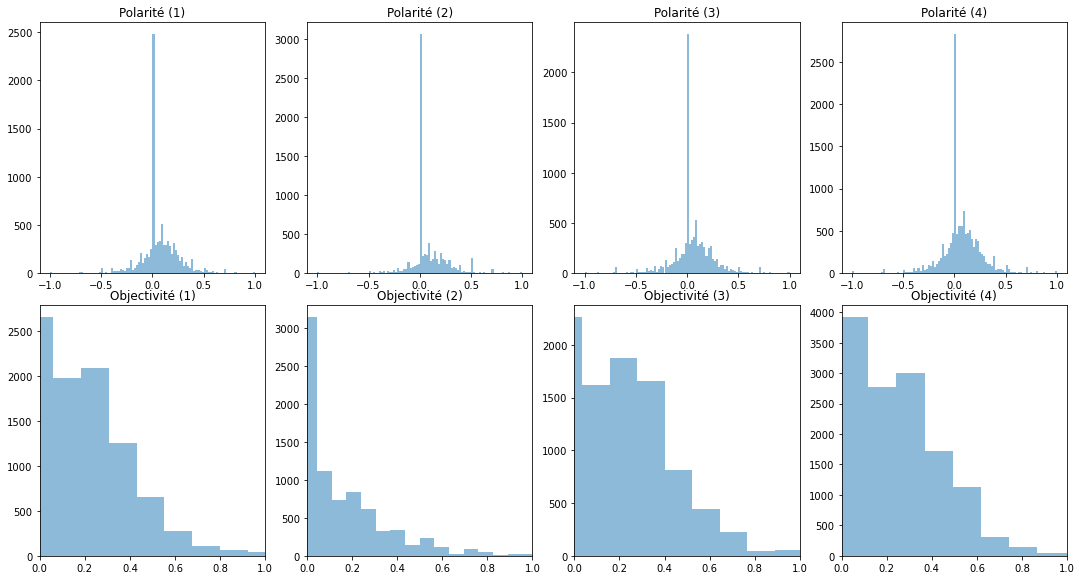

In [574]:
fig, ax = plt.subplots(2, 4,figsize=(15,8))
fig.tight_layout()

# dictionnaire afin de stocker les valeurs moyennes
emo_dict={}

for i in range(0,4):
    vect=[]
    ax_1=ax[0,i]
    ax_2=ax[1,i]
    polarities=[pol for pol in tw_data[tw_data['main_topic']==i]['polarity']]
    vect.append(np.mean(polarities))
    vect.append(np.percentile(polarities, 25))
    vect.append(np.percentile(polarities, 75))
    ax_1.hist(polarities,bins=100,alpha=0.5)
    ax_1.set_title('Polarité ('+str(i+1)+')')
    objectivity=[obj for obj in tw_data[tw_data['main_topic']==i]['objectivity']]
    vect.append(np.mean(objectivity))
    vect.append(np.percentile(objectivity, 25))
    vect.append(np.percentile(objectivity, 75))
    ax_2.hist(objectivity,bins=150,alpha=0.5)
    ax_2.set_title('Objectivité ('+str(i+1)+')')
    ax_2.set_xlim(0,1)
    emo_dict['Topic'+str(i+1)]=vect

plt.show()

In [575]:
# moyenne de polarité et d'objectivité
pd.DataFrame.from_dict(emo_dict, orient='index',dtype=None, columns=['Polarity_mean','Pol_Q1','Pol_Q3','Objectivity_mean','Obj_Q1','Obj_Q3'])

,Polarity_mean,Pol_Q1,Pol_Q3,Objectivity_mean,Obj_Q1,Obj_Q3
Topic1,0.065509,0.000000e+00,0.160536,0.210914,0.000,0.325000
Topic2,0.078123,0.000000e+00,0.162625,0.154228,0.000,0.241667
Topic3,0.047043,-2.500000e-03,0.147500,0.255479,0.025,0.350000
Topic4,0.064695,-4.394633e-18,0.160000,0.277728,0.100,0.375000


Tous les topics ont une polarité moyenne légèrement positive, ce qui ne permet pas de faire de vraies conclusions (on est assez déçu). Le topic 2 que l'on avait associé à des informations venus de médias est celui avec la plus forte objectivité ce qui semble aller dans notre sens. Les sujets 3 et 4 sont classés comme les plus subjectifs ce qui est aussi conforme avec notre analyse précédente. 

## 4) Analyse des sources

On s'intéresse aux utilisateurs les plus fréquents pour chacun des topics. On affiche les cinq premiers utilisateurs ainsi que leur nombre de tweets dans la catégorie et leur description.  

In [576]:
for i in range(0,4):
    print('Topic '+str(i+1))
    df=tw_data[tw_data['main_topic']==i]
    print(tabulate(df.groupby(['main_topic'])['user_name'].value_counts().groupby(level=[0]).head(5).reset_index(name='count'),tablefmt='pretty',showindex=False))
    print(df.groupby(['main_topic'])['user_description'].value_counts().groupby(level=[0]).head(5).reset_index(name='count')['user_description'])
    #print(tabulate(df.groupby(['main_topic'])['user_description'].value_counts().groupby(level=[0]).head(5).reset_index(name='count')['user_description'],tablefmt='pretty',showindex=False))

Topic 1
+---+---------------------------------------+----+
| 0 | Dr Jean-Jacques Fraslin - No #FakeMed | 23 |
| 0 |                   .                   | 20 |
| 0 |             StevePascolo              | 17 |
| 0 |            Eric Billy 🇫🇷🇪🇺            | 16 |
| 0 |               EVA REVE                | 15 |
+---+---------------------------------------+----+
0    Médecin généraliste.\nEn 2019, j'ai survécu gr...
1    co-fondateur CureVac. Expert vaccins ARN messa...
2    geneticist, #CRISPR, oncology/cancer, project ...
3    #Altruisme #Bienveillance #innovation #startup...
4    Neurones à la recherche de la vérité J’aime le...
Name: user_description, dtype: object
Topic 2
+---+---------------------------------------+----+
| 1 |             FranceNews24              | 23 |
| 1 |          Jean Marc Morandini          | 21 |
| 1 |          Dernières nouvelles          | 19 |
| 1 | Dr Jean-Jacques Fraslin - No #FakeMed | 19 |
| 1 |             Nashira News              | 19 |
+---+---

Les trois utilisateurs les plus présents dans le topic 1 semblent être des personnes qualifiées (un médecin, un expert de l'ARN et un généticien) ce qui nous conforte dans le thème scientifique du premier topic. On constate aussi que le topic 2 est bien relié avec les actualités et les médias. Il est encore une fois plus difficile de faire de vraies conclusions sur les deux derniers thèmes même si l'on remarque encore une fois que la subjectivité est de mise avec des descriptions d'utilisateurs telles que "pour plus de justice et de liberté - déteste le politiquement correct","je viens pour dire ce que je pense", "sortir de l'obscurantisme et contre la censure".  

In [592]:
# on code une nouvelle colonne pour savoir si le tweet est ou non une réponse adressée à un autre utilisateur
tw_data['reply_code']=tw_data['is_reply'].notnull()
# on affiche les données moyennes pour les utilisateurs de chaque topic
tw_data.groupby(['main_topic']).mean()

,tweet_id,tweet_location,is_retweet,is_quote_status,user_followers,user_favourites,user_verified,perc_main_topic,polarity,objectivity,reply_code
main_topic,,,,,,,,,,,
0,1348345382271465984,NaN,0.0,0.106126,12530.801108,15651.369867,0.025310,0.593985,0.065509,0.210914,0.647621
1,1348343911610714368,NaN,0.0,0.111616,37896.537753,15892.850000,0.077778,0.616366,0.078123,0.154228,0.335859
2,1348345009186707968,NaN,0.0,0.105875,6933.448926,16103.357409,0.015125,0.603317,0.047043,0.255479,0.700241
3,1348341928930643968,NaN,0.0,0.089850,5191.981594,15306.667418,0.009541,0.627719,0.064695,0.277728,0.756442


On remarque encore une fois que les utilisateurs du deuxième groupe semblent être des comptes plus "fiables" avec le plus fort pourcentage d'utilisateurs vérifiés et un nombre moyen de followers bien plus élevé que dans les autres groupes. Les groupes 1, 2 et 3 sont caractérisés par beaucoup d'échanges puisque 65% (groupe 1), 70% (groupe 3) et 75% (groupe 4) des tweets échangés sont des réponses ou des interpellations d'autre utilisateurs quand le groupe 2 (défini comme objectif) ne comporte qu'un tiers de tags d'utilisateurs. Au sein des ces trois groupes de débat on distingue le groupe 1 avec des utilisateurs plus influents (moyenne de 12 500 followers) contre des utilisateurs moins suivis dans les groupes 3 et 4. 

# V. Conclusion et limites

### Conclusion sur les topics

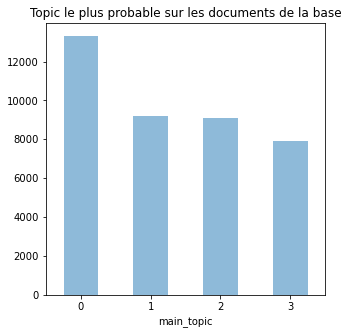

In [533]:
fig, ax = plt.subplots(figsize=(5,5))
topics=pd.DataFrame(tw_data['main_topic'],columns=['main_topic']).value_counts().sort_values(ascending=False)
topics.plot(kind='bar',ax=ax,alpha=0.5)
ax.set_title('Topic le plus probable sur les documents de la base')
ax.set_xticklabels(ax.get_xticks(), rotation = 0)
plt.show()

#### Pour récapituler on identifie quatre sujets à la lumière de cette étude : 
- un débat scientifique "éclairé" sur le vaccin et notamment ses spécificités (technologie ARN-m) où les utilisateurs échangent en utilisant des thèmes scientifiques et où des "experts" (médecins) semblent représentés (topic 1)
- des informations objectives sur l'actualité vaccinale provenant principalement de médias (topic 2)
- des débats très subjectifs d'utilisateurs moins influents autour de la pandémie et de la vie en tant de Covid sans forcément débattre expressément de la vaccination (topic 3)
- un débat très subjectif également centré autour des risques/avantages de la vaccination (topic 4)

D'après la répartition des topics, les tweets les plus présents sont ceux qui adoptent un vocabulaire scientifique et technique pour parler du vaccin ce qui reflète les débats spécifiques liés à la nouvelle technologie d'ARN-m utilisé dans les nouveaux vaccins. Le mot "arn" était d'ailleurs un des plus saillants du topic montrant qu'il est la source de nombreux débats. On peut également constater que les tweets objectifs et neutres (associés le plus souvent à la presse) représentent à peine 25% des tweets échangés sur le sujet du vaccin. 

### Limites et suites à donner
- les interprétations de nos groupes sont forcément très subjectives
- le fait d'avoir utilisé un modèle de LDA présente les mêmes défauts que le recours à un bag of words puisque chaque mot est analysé indépendamment des liens qu'il peut avoir avec d'autres mots. De plus certains mots très ressemblants (fautes d'orthographe ou même radical) n'ont pas été rassemblés par le modèle. Nous avions essayé un modèle avec radicalisation mais le manque d'interprétabilité du modèle sans gain significatif de cohérence nous a conduit à privilégier le modèle de base. 
- la quantité de tweets limités ne permet que de réfléter l'opinion sur la semaine étudiée. L'API de Twitter nous limitant à une semaine de données il faudrait poursuivre l'étude pour étudier des variations d'opinion en fonction de nouvelles annonces.
- enfin la population de Twitter n'est pas représentative de la population française et a tendance à plus catalyser les opinions extrêmes comme tout réseau social